# start

In [1]:
! export GLBACKEND="pytorch"
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import glob
import dgl
import torch 
from dgl.nn import GraphConv
from script.utils3 import Get_DGL
from torch.utils.data import Dataset
import time
import pandas as pd
from pandas import DataFrame
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import axes
from matplotlib.font_manager import FontProperties

import warnings

Using backend: pytorch[10:05:38] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory



In [2]:
data_file = '../data2/data2.csv'
mol_dir = '../data2/data2_sdf_files/'

In [3]:
tmp_df = pd.read_csv(data_file)
cat_smiles = tmp_df['Catalyst'].to_list()
imine_smiles = tmp_df['Imine'].to_list()
thiol_smiles = tmp_df['Thiol'].to_list()
labels_ori = tmp_df['Output'].to_list()

cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))
labels_ori=np.array(labels_ori)

In [4]:
cat_files = glob.glob(mol_dir+'cat_*.sdf')
imine_files = glob.glob(mol_dir+'imine_*.sdf')
thiol_files = glob.glob(mol_dir+'thiol_*.sdf')

In [5]:
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()

smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [6]:
cat_file_graph_dict = {}
all_desc_max = []
all_desc_min = []
for tmp_file in cat_files:
    tmp_file_name = tmp_file.split('/')[-1].split('.')[0]
    tmp_g = Get_DGL(tmp_file)
    cat_file_graph_dict[tmp_file_name] = tmp_g
    tmp_desc_max = np.array(tmp_g.ndata['feat']).max(axis=0)
    tmp_desc_min = np.array(tmp_g.ndata['feat']).min(axis=0)
    all_desc_max.append(tmp_desc_max)
    all_desc_min.append(tmp_desc_min)
    print(tmp_file_name)
all_desc_max = np.array(all_desc_max)
all_desc_min = np.array(all_desc_min)
desc_max = all_desc_max.max(axis=0)
desc_min = all_desc_min.min(axis=0)
for key in cat_file_graph_dict:
    cat_file_graph_dict[key].ndata['feat_std'] = (cat_file_graph_dict[key].ndata['feat'] - torch.tensor(desc_min))/(torch.tensor(desc_max) - torch.tensor(desc_min))


cat_34
cat_35
cat_25
cat_21
cat_27
cat_12
cat_14
cat_0
cat_24
cat_16
cat_38
cat_20
cat_9
cat_11
cat_28
cat_22
cat_18
cat_30
cat_5
cat_33
cat_15
cat_31
cat_26
cat_8
cat_19
cat_37
cat_1
cat_39
cat_7
cat_36
cat_29
cat_2
cat_13
cat_23
cat_6
cat_32
cat_41
cat_10
cat_17
cat_4
cat_42
cat_3
cat_40


In [10]:
thiol_file_graph_dict = {}
all_desc_max = []
all_desc_min = []
for tmp_file in thiol_files:
    tmp_file_name = tmp_file.split('/')[-1].split('.')[0]
    tmp_g = Get_DGL(tmp_file)
    thiol_file_graph_dict[tmp_file_name] = tmp_g
    tmp_desc_max = np.array(tmp_g.ndata['feat']).max(axis=0)
    tmp_desc_min = np.array(tmp_g.ndata['feat']).min(axis=0)
    all_desc_max.append(tmp_desc_max)
    all_desc_min.append(tmp_desc_min)
    print(tmp_file_name)
all_desc_max = np.array(all_desc_max)
all_desc_min = np.array(all_desc_min)
desc_max = all_desc_max.max(axis=0)
desc_min = all_desc_min.min(axis=0)
for key in thiol_file_graph_dict:
    thiol_file_graph_dict[key].ndata['feat_std'] = (thiol_file_graph_dict[key].ndata['feat'] - torch.tensor(desc_min))/(torch.tensor(desc_max) - torch.tensor(desc_min))


thiol_4
thiol_1
thiol_2
thiol_0
thiol_3


In [11]:
imine_file_graph_dict = {}
all_desc_max = []
all_desc_min = []
for tmp_file in imine_files:
    tmp_file_name = tmp_file.split('/')[-1].split('.')[0]
    tmp_g = Get_DGL(tmp_file)
    imine_file_graph_dict[tmp_file_name] = tmp_g
    tmp_desc_max = np.array(tmp_g.ndata['feat']).max(axis=0)
    tmp_desc_min = np.array(tmp_g.ndata['feat']).min(axis=0)
    all_desc_max.append(tmp_desc_max)
    all_desc_min.append(tmp_desc_min)
    print(tmp_file_name)
all_desc_max = np.array(all_desc_max)
all_desc_min = np.array(all_desc_min)
desc_max = all_desc_max.max(axis=0)
desc_min = all_desc_min.min(axis=0)
for key in imine_file_graph_dict:
    imine_file_graph_dict[key].ndata['feat_std'] = (imine_file_graph_dict[key].ndata['feat'] - torch.tensor(desc_min))/(torch.tensor(desc_max) - torch.tensor(desc_min))

imine_1
imine_4
imine_3
imine_2
imine_0


In [63]:
class Graph_DataSet(Dataset):

    def __init__(self, root, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        #如果是训练则加载训练集，如果是测试则加载测试集
        if self.train :
            file_annotation = root + '/data2.csv' 
            sdf_folder = root + '/data2_sdf_files/'
        else:
            file_annotation = root + '/test.csv' 
            sdf_folder = root + '/test_sdf/'
        df = pd.read_csv(file_annotation)
 
        #data_dict = df[['molecule','CV']]
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        cat_smi = df['Catalyst'].to_list()
        imine_smi = df['Imine'].to_list()
        thiol_smi = df['Thiol'].to_list()
        
        
        cat_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in cat_smi]
        imine_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in imine_smi]
        thiol_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in thiol_smi]
        
        self.cat_file_names = cat_file_names
        self.imine_file_names = imine_file_names
        self.thiol_file_names = thiol_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        #mol_name = self.filenames[index]
        cat_name = self.cat_file_names[index]
        imine_name = self.imine_file_names[index]
        thiol_name = self.thiol_file_names[index]
        label = self.target_std[index]

        graph_1 = cat_file_graph_dict[cat_name]
        graph_2 = imine_file_graph_dict[imine_name]
        graph_3 = thiol_file_graph_dict[thiol_name]
        
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

In [61]:
dataset = Graph_DataSet('../data2')

In [62]:
g1=dataset[0][0][0]
g2=dataset[0][0][2]
g3=dataset[0][0][4]
x1=g1.ndata['feat']
x2=g2.ndata['feat']
x3=g3.ndata['feat']

In [26]:
super_node_feat=torch.cat([x1,x2,x3],axis=0)

<bound method DGLHeteroGraph.get_ntype_id of Graph(num_nodes=58, num_edges=128,
      ndata_schemes={'feat': Scheme(shape=(543,), dtype=torch.float32), 'feat_std': Scheme(shape=(543,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})>

In [33]:
g1.ndata['feat'].shape

torch.Size([58, 543])

In [35]:
super_bond_feat

torch.Size([98, 543])

In [ ]:
def _preprocess(self, x: dict) -> dict:
    oh_atom_feats = []
    for i, key in self.numbered_atom_oh_keys:
        oh_feat = to_one_hot(x['node_features'][:, :, i], dims=len(self.prop2oh['atom'][key]) + 1)
        oh_atom_feats.append(oh_feat)
    # noinspection PyTypeChecker
    atom_feats = torch.cat(oh_atom_feats, dim=-1)

    x['node_features'] = atom_feats

    # "node_adj_mask" has shape fo the adjacency matrix and puts 1 in every place where a bond is possible
    node_adj_mask = x['node_mask'].unsqueeze(-1)
    node_adj_mask = node_adj_mask.expand(*node_adj_mask.shape)
    node_adj_mask = node_adj_mask * node_adj_mask.permute(0, 2, 1, 3).contiguous()
    x['node_adj_mask'] = node_adj_mask

    conv_mask = x['adj_mask'].float().squeeze(-1)

    # two different masks are needed to mask for softmax activation
    conv_soft_mask = (-conv_mask + 1.0) * -1e9
    x['conv_mask'] = conv_mask
    x['conv_soft_mask'] = conv_soft_mask

    oh_bond_feats = []
    for i, key in self.numbered_bond_oh_keys:
        oh_feat = to_one_hot(x['adj'][:, :, :, i], dims=len(self.prop2oh['bond'][key]) + 1)
        oh_bond_feats.append(oh_feat)
    # noinspection PyTypeChecker
    adj = torch.cat(oh_bond_feats, dim=-1)
    x['adj'] = adj

    x['node_features'] = self.atom_embedding(x['node_features'])
    x['adj'] = self.bond_embedding(x['adj'])

    if self.reaction_type_given:
        reaction_type = x['reaction_type']
        r_type_emb = self.reaction_type_embedding(reaction_type)
        r_type_emb = r_type_emb.unsqueeze(1).expand(-1, x['node_features'].shape[1], -1)

        x['node_features'] = torch.cat((x['node_features'], r_type_emb), dim=-1)

        r_type_emb = r_type_emb.unsqueeze(2).expand(-1, -1, x['node_features'].shape[1], -1)
        x['adj'] = torch.cat((x['adj'], r_type_emb), dim=-1)

    return x

In [ ]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()      
        
        #self.conv1 = dgl.nn.SGConv(in_features, hidden_features,  k=2, cached=True)
        #self.conv2 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        #self.conv3 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        
        #self.conv1 = dgl.nn.SAGEConv(in_features, hidden_features, 'pool')
        #self.conv2 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
        #self.conv3 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
                
        #self.conv1 = dgl.nn.EdgeConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        
        #self.conv1 = dgl.nn.GATConv(in_features, hidden_features, num_heads=3)
        #self.conv2 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        #self.conv3 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        
        #self.conv1 = dgl.nn.TAGConv(in_features, hidden_features, k=4)
        #self.conv2 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        #self.conv3 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        
        #self.conv1 = dgl.nn.RelGraphConv(in_features, hidden_features, 4, num_bases=4)
        #self.conv2 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4 , num_bases=4)
        #self.conv3 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4, num_bases=4)
        #etype = np.ones(186).astype(np.int64)
        
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.GraphConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.GraphConv(hidden_features, hidden_features)
       
        self.fc1   = nn.Linear(304,128) 
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 1)

    def forward(self,g1,x1,g2,x2,g3,x3,multi_graph_opt='mean',output_opt='mean'):
        
        x1 = F.relu(self.conv1(g1, x1))
        #x1 = F.relu(self.conv2(g1, x1))
        #x1 = F.relu(self.conv3(g1, x1))
        #x1=torch.mean(x1,axis=0).reshape(-1,1)
        #x1t=x1.transpose(-1,0)
        #x1t=x1.reshape(-1,200)
       
        x2 = F.relu(self.conv1(g2, x2))
        #x2 = F.relu(self.conv2(g2, x2))
        #x2 = F.relu(self.conv3(g2, x2))
        #x2=torch.mean(x2,axis=0).reshape(-1,1)
        #x2t=x2.transpose(-1,0)
        #x2t=x2.reshape(-1,200)
        
        x3 = F.relu(self.conv1(g3, x3))
        #x3 = F.relu(self.conv2(g3, x3))
        #x3 = F.relu(self.conv3(g3, x3))
        #x3=torch.mean(x3,axis=0).reshape(-1,1)
        #x3t=x3.transpose(-1,0)
        #x3t=x3.reshape(-1,200)
        
        
        if multi_graph_opt == 'mean':
            x = torch.mean(torch.cat([x1,x2,x3],axis=0),axis=0)
           
        elif multi_graph_opt == 'sum':
            x = torch.sum(torch.cat([x1,x2,x3],axis=0),axis=0)
        
        if output_opt == 'mean':
            x = F.torch.mean(x)
        elif output_opt == 'sum':
            x = F.torch.sum(x)
        '''x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))'''
        
        return x

In [ ]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../denmark')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model = StochasticTwoLayerGCN(543,256,1)
#optimizer = optim.Adam(model.parameters())
#loss_func = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')

for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

#hist = model.fit_generator(train_data,validation_data=val_data,epochs=100,callbacks=[checkpoint])

In [59]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        self.conv2 = dgl.nn.GraphConv(hidden_features, hidden_features)
        self.conv3 = dgl.nn.GraphConv(hidden_features, out_features)
        self.fc1   = nn.Linear(1024,512) 
        self.fc2   = nn.Linear(512, 256)
        self.fc3   = nn.Linear(256, 1)

    def forward(self,g1,x1,g2,x2,g3,x3,multi_graph_opt='mean',output_opt='mean'):
        
        x1 = F.relu(self.conv1(g1, x1))
        x1 = F.relu(self.conv2(g1, x1))
        x1 = F.relu(self.conv3(g1, x1))
        
        x2 = F.relu(self.conv1(g2, x2))
        x2 = F.relu(self.conv2(g2, x2))
        x2 = F.relu(self.conv3(g2, x2))
        
        x3 = F.relu(self.conv1(g3, x3))
        x3 = F.relu(self.conv2(g3, x3))
        x3 = F.relu(self.conv3(g3, x3))
        
        if multi_graph_opt == 'mean':
            x = torch.mean(torch.cat([x1,x2,x3],axis=0),axis=0)
        elif multi_graph_opt == 'sum':
            x = torch.sum(torch.cat([x1,x2,x3],axis=0),axis=0)
        
        if output_opt == 'mean':
            x = F.torch.mean(x)
        elif output_opt == 'sum':
            x = F.torch.sum(x)
        return x

# model

In [82]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()      
        
        #self.conv1 = dgl.nn.SGConv(in_features, hidden_features,  k=2, cached=True)
        #self.conv2 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        #self.conv3 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        
        #self.conv1 = dgl.nn.SAGEConv(in_features, hidden_features, 'pool')
        #self.conv2 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
        #self.conv3 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
                
        #self.conv1 = dgl.nn.EdgeConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        
        #self.conv1 = dgl.nn.GATConv(in_features, hidden_features, num_heads=3)
        #self.conv2 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        #self.conv3 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        
        #self.conv1 = dgl.nn.TAGConv(in_features, hidden_features, k=4)
        #self.conv2 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        #self.conv3 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        
        #self.conv1 = dgl.nn.RelGraphConv(in_features, hidden_features, 4, num_bases=4)
        #self.conv2 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4 , num_bases=4)
        #self.conv3 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4, num_bases=4)
        #etype = np.ones(186).astype(np.int64)
        
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.GraphConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.GraphConv(hidden_features, hidden_features)
       
        self.fc1   = nn.Linear(304,128) 
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 1)

    def forward(self,g1,x1,g2,x2,g3,x3,multi_graph_opt='mean',output_opt='mean'):
        
        x1 = F.relu(self.conv1(g1, x1))
        #x1 = F.relu(self.conv2(g1, x1))
        #x1 = F.relu(self.conv3(g1, x1))
        #x1=torch.mean(x1,axis=0).reshape(-1,1)
        #x1t=x1.transpose(-1,0)
        #x1t=x1.reshape(-1,200)
       
        x2 = F.relu(self.conv1(g2, x2))
        #x2 = F.relu(self.conv2(g2, x2))
        #x2 = F.relu(self.conv3(g2, x2))
        #x2=torch.mean(x2,axis=0).reshape(-1,1)
        #x2t=x2.transpose(-1,0)
        #x2t=x2.reshape(-1,200)
        
        x3 = F.relu(self.conv1(g3, x3))
        #x3 = F.relu(self.conv2(g3, x3))
        #x3 = F.relu(self.conv3(g3, x3))
        #x3=torch.mean(x3,axis=0).reshape(-1,1)
        #x3t=x3.transpose(-1,0)
        #x3t=x3.reshape(-1,200)
        
        
        if multi_graph_opt == 'mean':
            x = torch.mean(torch.cat([x1,x2,x3],axis=0),axis=0)
           
        elif multi_graph_opt == 'sum':
            x = torch.sum(torch.cat([x1,x2,x3],axis=0),axis=0)
        
        if output_opt == 'mean':
            x = F.torch.mean(x)
        elif output_opt == 'sum':
            x = F.torch.sum(x)
        '''x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))'''
        
        return x

# train

## random

In [83]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../data2')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [84]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model = StochasticTwoLayerGCN(543,256,1)
#optimizer = optim.Adam(model.parameters())
#loss_func = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')
all_test=[]
all_pred=[]

for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    all_test.append(test_all_labels)
    all_pred.append(test_get_output)
    print('Test MSE',np.mean(all_loss))   

#hist = model.fit_generator(train_data,validation_data=val_data,epochs=100,callbacks=[checkpoint])

Train MSE 0.1464076
Test MSE 0.11892576
Train MSE 0.112790436
Test MSE 0.09542968
Train MSE 0.09899863
Test MSE 0.08422992
Train MSE 0.088513784
Test MSE 0.07896414
Train MSE 0.08022787
Test MSE 0.0710841
Train MSE 0.075479485
Test MSE 0.064003445
Train MSE 0.07101044
Test MSE 0.06136717
Train MSE 0.06957314
Test MSE 0.05991734
Train MSE 0.06768505
Test MSE 0.06559394
Train MSE 0.067123085
Test MSE 0.060106695
Train MSE 0.06521947
Test MSE 0.057063147
Train MSE 0.06494072
Test MSE 0.05961193
Train MSE 0.0662735
Test MSE 0.057740703
Train MSE 0.06464165
Test MSE 0.058206562
Train MSE 0.06436181
Test MSE 0.057288628
Train MSE 0.064967565
Test MSE 0.060532026
Train MSE 0.06445921
Test MSE 0.058738034
Train MSE 0.063883945
Test MSE 0.056483027
Train MSE 0.064459674
Test MSE 0.06034316
Train MSE 0.062983185
Test MSE 0.057673573
Train MSE 0.064068474
Test MSE 0.059478525
Train MSE 0.062615566
Test MSE 0.05724904
Train MSE 0.06305011
Test MSE 0.06391822
Train MSE 0.062096074
Test MSE 0.059238

In [134]:
dataset = Graph_DataSet('../Dataset')
model = StochasticTwoLayerGCN(543,256,1)

#criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()
#get_output=[]
for epoch in range(25):
    get_output=[]
    all_loss = []
    for i, data in enumerate(dataset):
        inputs, labels = data

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print(np.mean(all_loss))

0.08289232008846192
0.0772932016343095
0.07357060035187397
0.06961874762613479
0.06607105490763851
0.06389063332936802
0.060866310800962456
0.05806280071465092
0.05751521642082187
0.05461527398779856
0.05489390896359513
0.0540394675115386
0.05239628637028073
0.05139602470860277
0.05008933713117093
0.05019594626045908
0.04972508196340616
0.04894870547255421
0.048819151326932014
0.04830458181660206
0.04920832224643318
0.048075766961068286
0.04832907369198469
0.04858938194263305
0.04841780040903706


In [21]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())

In [87]:
len(all_test)

50

In [126]:
test_all_labels_=[]
for i in all_test[49]:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in all_pred[49]:
    test_get_output_.append(i.tolist())

In [127]:
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

In [134]:
all_rmse=[]
all_r2=[]
all_test_=[]
all_pred_=[]
for m in list(range(40,50)):
    test_all_labels_=[]
    for i in all_test[m]:
        test_all_labels_.append(i.tolist())

    test_get_output_=[]
    for i in all_pred[m]:
        test_get_output_.append(i.tolist())
    y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
    y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()  
    rmse=np.round((mean_squared_error(y_val,y_pred))**(0.5),3)
    r2=np.round(r2_score(y_val,y_pred),3)
    all_test_.append(test_all_labels_)
    all_pred_.append(test_get_output_)
    all_rmse.append(rmse)
    all_r2.append(r2)
    print(rmse,r2)

0.287 0.808
0.29 0.803
0.295 0.797
0.295 0.796
0.303 0.785
0.29 0.803
0.295 0.796
0.301 0.788
0.286 0.809
0.291 0.802


In [125]:
np.mean(rmse),np.mean(r2),

(0.291, 0.802)

In [136]:
len(all_test_)

10

In [135]:
np.save('./dataset/se_gcn_all_test.npy',all_test_)
np.save('./dataset/se_gcn_all_pred.npy',all_pred_)

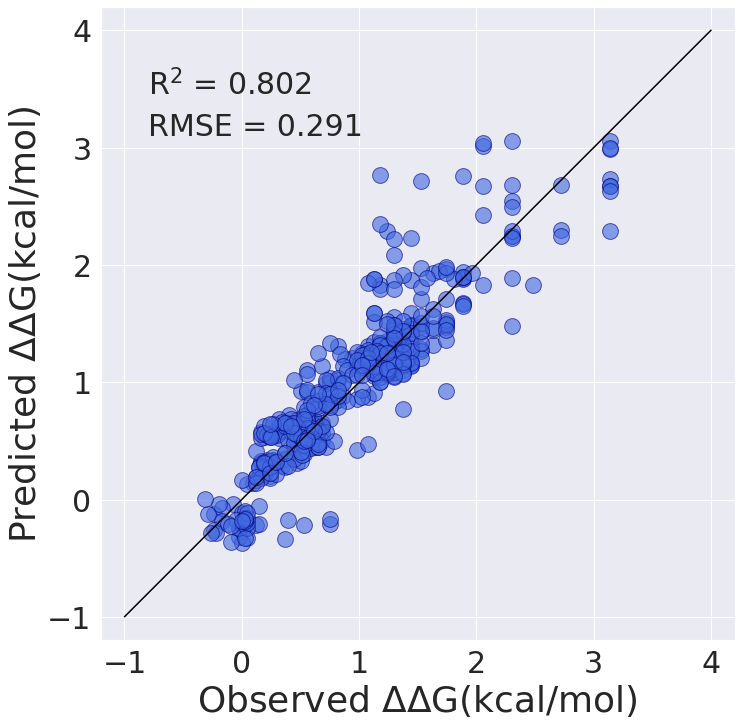

In [128]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')


plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
#ax.set_facecolor('oldlace')
#ax.set_facecolor('')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
plt.ylabel("Predicted $\Delta$$\Delta$G(kcal/mol)",fontsize=36)
#plt.title('doyle',fontsize=14)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()


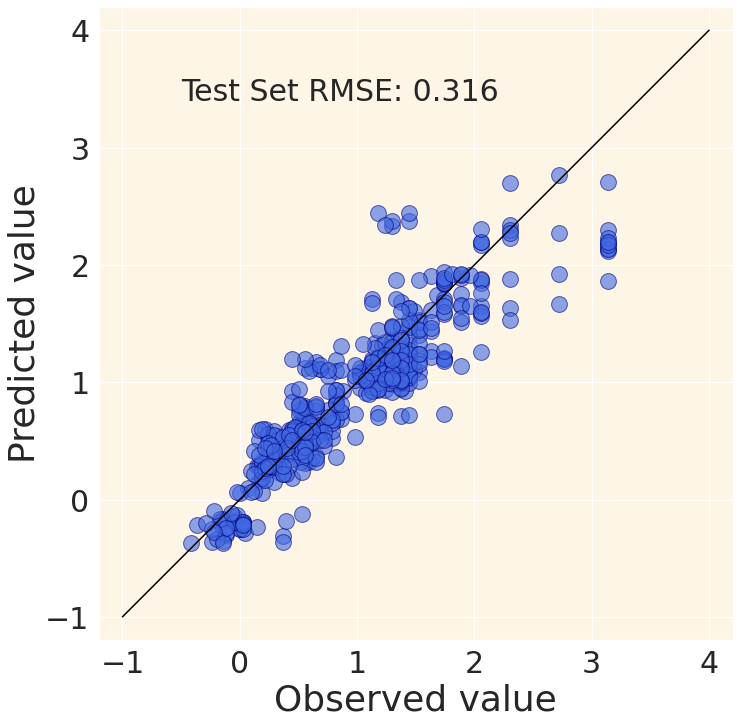

In [23]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')


#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.title('doyle',fontsize=14)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_val,y_pred),fontsize=24)


plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()
#fig.savefig('./Dataset/denmark_random_fig.png',dpi=400)
#depth4   hidden_size128,0.244   256  0.225
#depth3    hidden_size128       5   128   0.247  5   256   0.224

In [80]:
np.save( './run_data/data2_se_gcn_random_y_val.npy',y_val)
np.save( './run_data/data2_se_gcn_random_y_pred.npy',y_pred)

## low

In [64]:
ee = np.round((np.exp(labels_ori*4184/(8.314*298.15)) - 1)/(np.exp(labels_ori*4184/(8.314*298.15))+1),decimals=2)

In [65]:
len(low_data_index),len(high_data_index)

(718, 357)

In [66]:
loss = 'mse'
batch_size = 128

low_data_index = np.where((ee<0.8))[0]
high_data_index = np.where((ee>=0.8))[0]
dataset = Graph_DataSet('../data2')
train_data=[]
for i in low_data_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in high_data_index:
    tem_data=dataset[i]
    val_data.append(tem_data)    

In [72]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
model = StochasticTwoLayerGCN(543,256,1)
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()
checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')

for epoch in range(100):
    train_predict=[]
    train_ori=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        train_predict.append(outputs)
        train_ori.append(labels)
        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model.eval()
    
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

#hist = model.fit_generator(train_data,validation_data=val_data,epochs=100,callbacks=[checkpoint])

Train MSE 0.08228271
Test MSE 0.3293714
Train MSE 0.05927921
Test MSE 0.31507093
Train MSE 0.054798573
Test MSE 0.31145784
Train MSE 0.05551046
Test MSE 0.30305085
Train MSE 0.05319993
Test MSE 0.28394532
Train MSE 0.049882244
Test MSE 0.2884472
Train MSE 0.048289876
Test MSE 0.27048323
Train MSE 0.048982006
Test MSE 0.26487634
Train MSE 0.04386631
Test MSE 0.2423605
Train MSE 0.045952544
Test MSE 0.2420824
Train MSE 0.045358274
Test MSE 0.20934576
Train MSE 0.043793686
Test MSE 0.20693104
Train MSE 0.04463489
Test MSE 0.19313157
Train MSE 0.04355851
Test MSE 0.18890901
Train MSE 0.043197285
Test MSE 0.16896059
Train MSE 0.04341334
Test MSE 0.1525938
Train MSE 0.043431465
Test MSE 0.15019779
Train MSE 0.042637125
Test MSE 0.14948377
Train MSE 0.042271845
Test MSE 0.13164268
Train MSE 0.042089734
Test MSE 0.13580766
Train MSE 0.040799957
Test MSE 0.13751432
Train MSE 0.04060864
Test MSE 0.13987534
Train MSE 0.040067215
Test MSE 0.13796432
Train MSE 0.039568804
Test MSE 0.12549193
Train 

In [73]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
    
train_predict_=[]    
for i in train_predict:
    train_predict_.append(i.tolist())    

In [74]:
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_val_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_train=np.array(train_ori)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_train_pred=np.array(train_predict_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

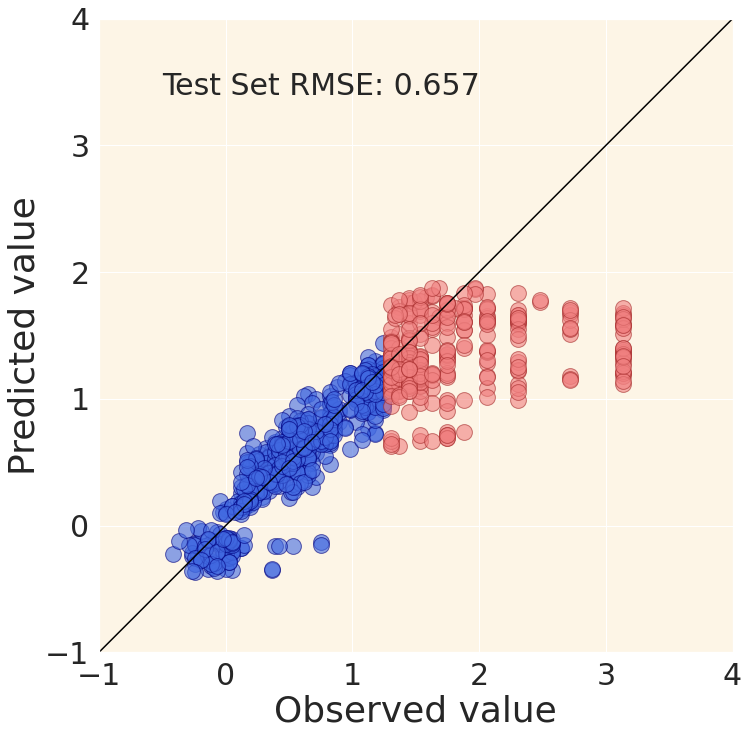

In [75]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
sns.set(style='darkgrid')
#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_train,y_train_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_val,y_val_pred,s=250, c='lightcoral', label="samples",alpha=0.6,edgecolors='brown')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
plt.xlim(-1,4)
plt.ylim(-1,4)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.title('doyle',fontsize=14)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_val,y_val_pred))**(0.5),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
#fig.savefig('./Dataset/denmark_low_fig.png',dpi=400)

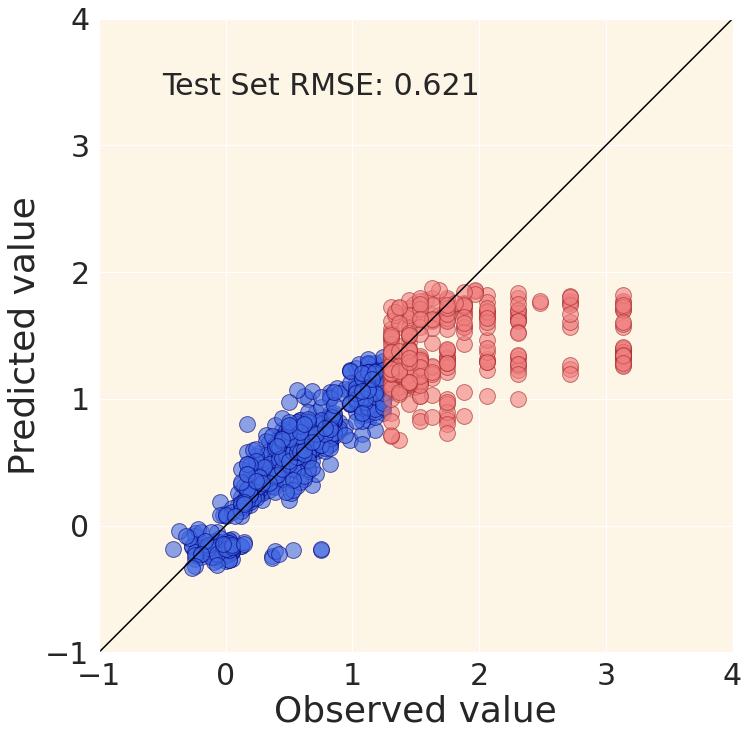

In [70]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
sns.set(style='darkgrid')
#display.set_matplotlib_formats('svg')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_train,y_train_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.scatter(y_val,y_val_pred,s=250, c='lightcoral', label="samples",alpha=0.6,edgecolors='brown')
plt.plot([-1,4],[-1,4],c='black')
'''x = np.arange(-1,5)
y = x
l = plt.plot(x,y)
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.fill_between(x,x+0.5,x-0.5,alpha=0.2,color='yellow')'''
plt.xlim(-1,4)
plt.ylim(-1,4)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.set_facecolor('oldlace')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.title('doyle',fontsize=14)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(-0.5,3.4,'Test Set RMSE: %.3f'%(mean_squared_error(y_val,y_val_pred))**(0.5),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_test_for_draw,y_test_pred_for_draw),fontsize=24)
#fig.savefig('./Dataset/denmark_low_fig.png',dpi=400)

In [76]:
np.save( './run_data/data2_se_gcn_low_y_val.npy',y_val)
np.save( './run_data/data2_se_gcn_low_y_val_pred.npy',y_val_pred)
np.save( './run_data/data2_se_gcn_low_y_train.npy',y_train)
np.save( './run_data/data2_se_gcn_low_y_train_pred.npy',y_train_pred)